Importação de bibliotecas e framewoks

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Tabela_Organossolve.csv', index_col = 0)
df = df.rename(index={'Porcentagem (%)': 'Concentração de etanol (%)'})
Dados = df.T
Dados

Experimento,Temperatura (°C),Tempo (min),Concentração de etanol (%),Celulose,Hemicelulose,Lignina Total,Cinzas,Total,Rendimento (%)
1,150.0,30.0,30.0,48.1,24.8,21.6,2.1,96.6,80.7
2,150.0,30.0,50.0,49.1,26.4,21.2,3.1,99.8,76.8
3,150.0,30.0,70.0,47.2,26.9,21.0,4.1,99.7,82.2
4,170.0,60.0,30.0,73.9,10.5,14.8,1.9,101.1,50.7
5,170.0,60.0,50.0,65.1,17.9,12.0,2.1,97.1,59.3
6,170.0,60.0,70.0,53.0,22.6,17.7,5.3,98.6,72.5
7,190.0,90.0,30.0,79.3,30.4,11.8,5.5,99.6,45.9
8,190.0,90.0,50.0,82.0,6.7,5.5,5.0,99.2,46.8
9,190.0,90.0,70.0,70.8,14.3,8.8,5.9,99.8,54.1


In [3]:
Dados.describe()

Experimento,Temperatura (°C),Tempo (min),Concentração de etanol (%),Celulose,Hemicelulose,Lignina Total,Cinzas,Total,Rendimento (%)
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,170.000000,60.000000,50.000000,63.166667,20.055556,14.933333,3.888889,99.055556,63.222222
std,17.320508,25.980762,17.320508,14.032819,8.143573,5.844014,1.615893,1.417843,14.837518
min,150.000000,30.000000,30.000000,47.200000,6.700000,5.500000,1.900000,96.600000,45.900000
25%,150.000000,30.000000,30.000000,49.100000,14.300000,11.800000,2.100000,98.600000,50.700000
50%,170.000000,60.000000,50.000000,65.100000,22.600000,14.800000,4.100000,99.600000,59.300000
75%,190.000000,90.000000,70.000000,73.900000,26.400000,21.000000,5.300000,99.800000,76.800000
max,190.000000,90.000000,70.000000,82.000000,30.400000,21.600000,5.900000,101.100000,82.200000


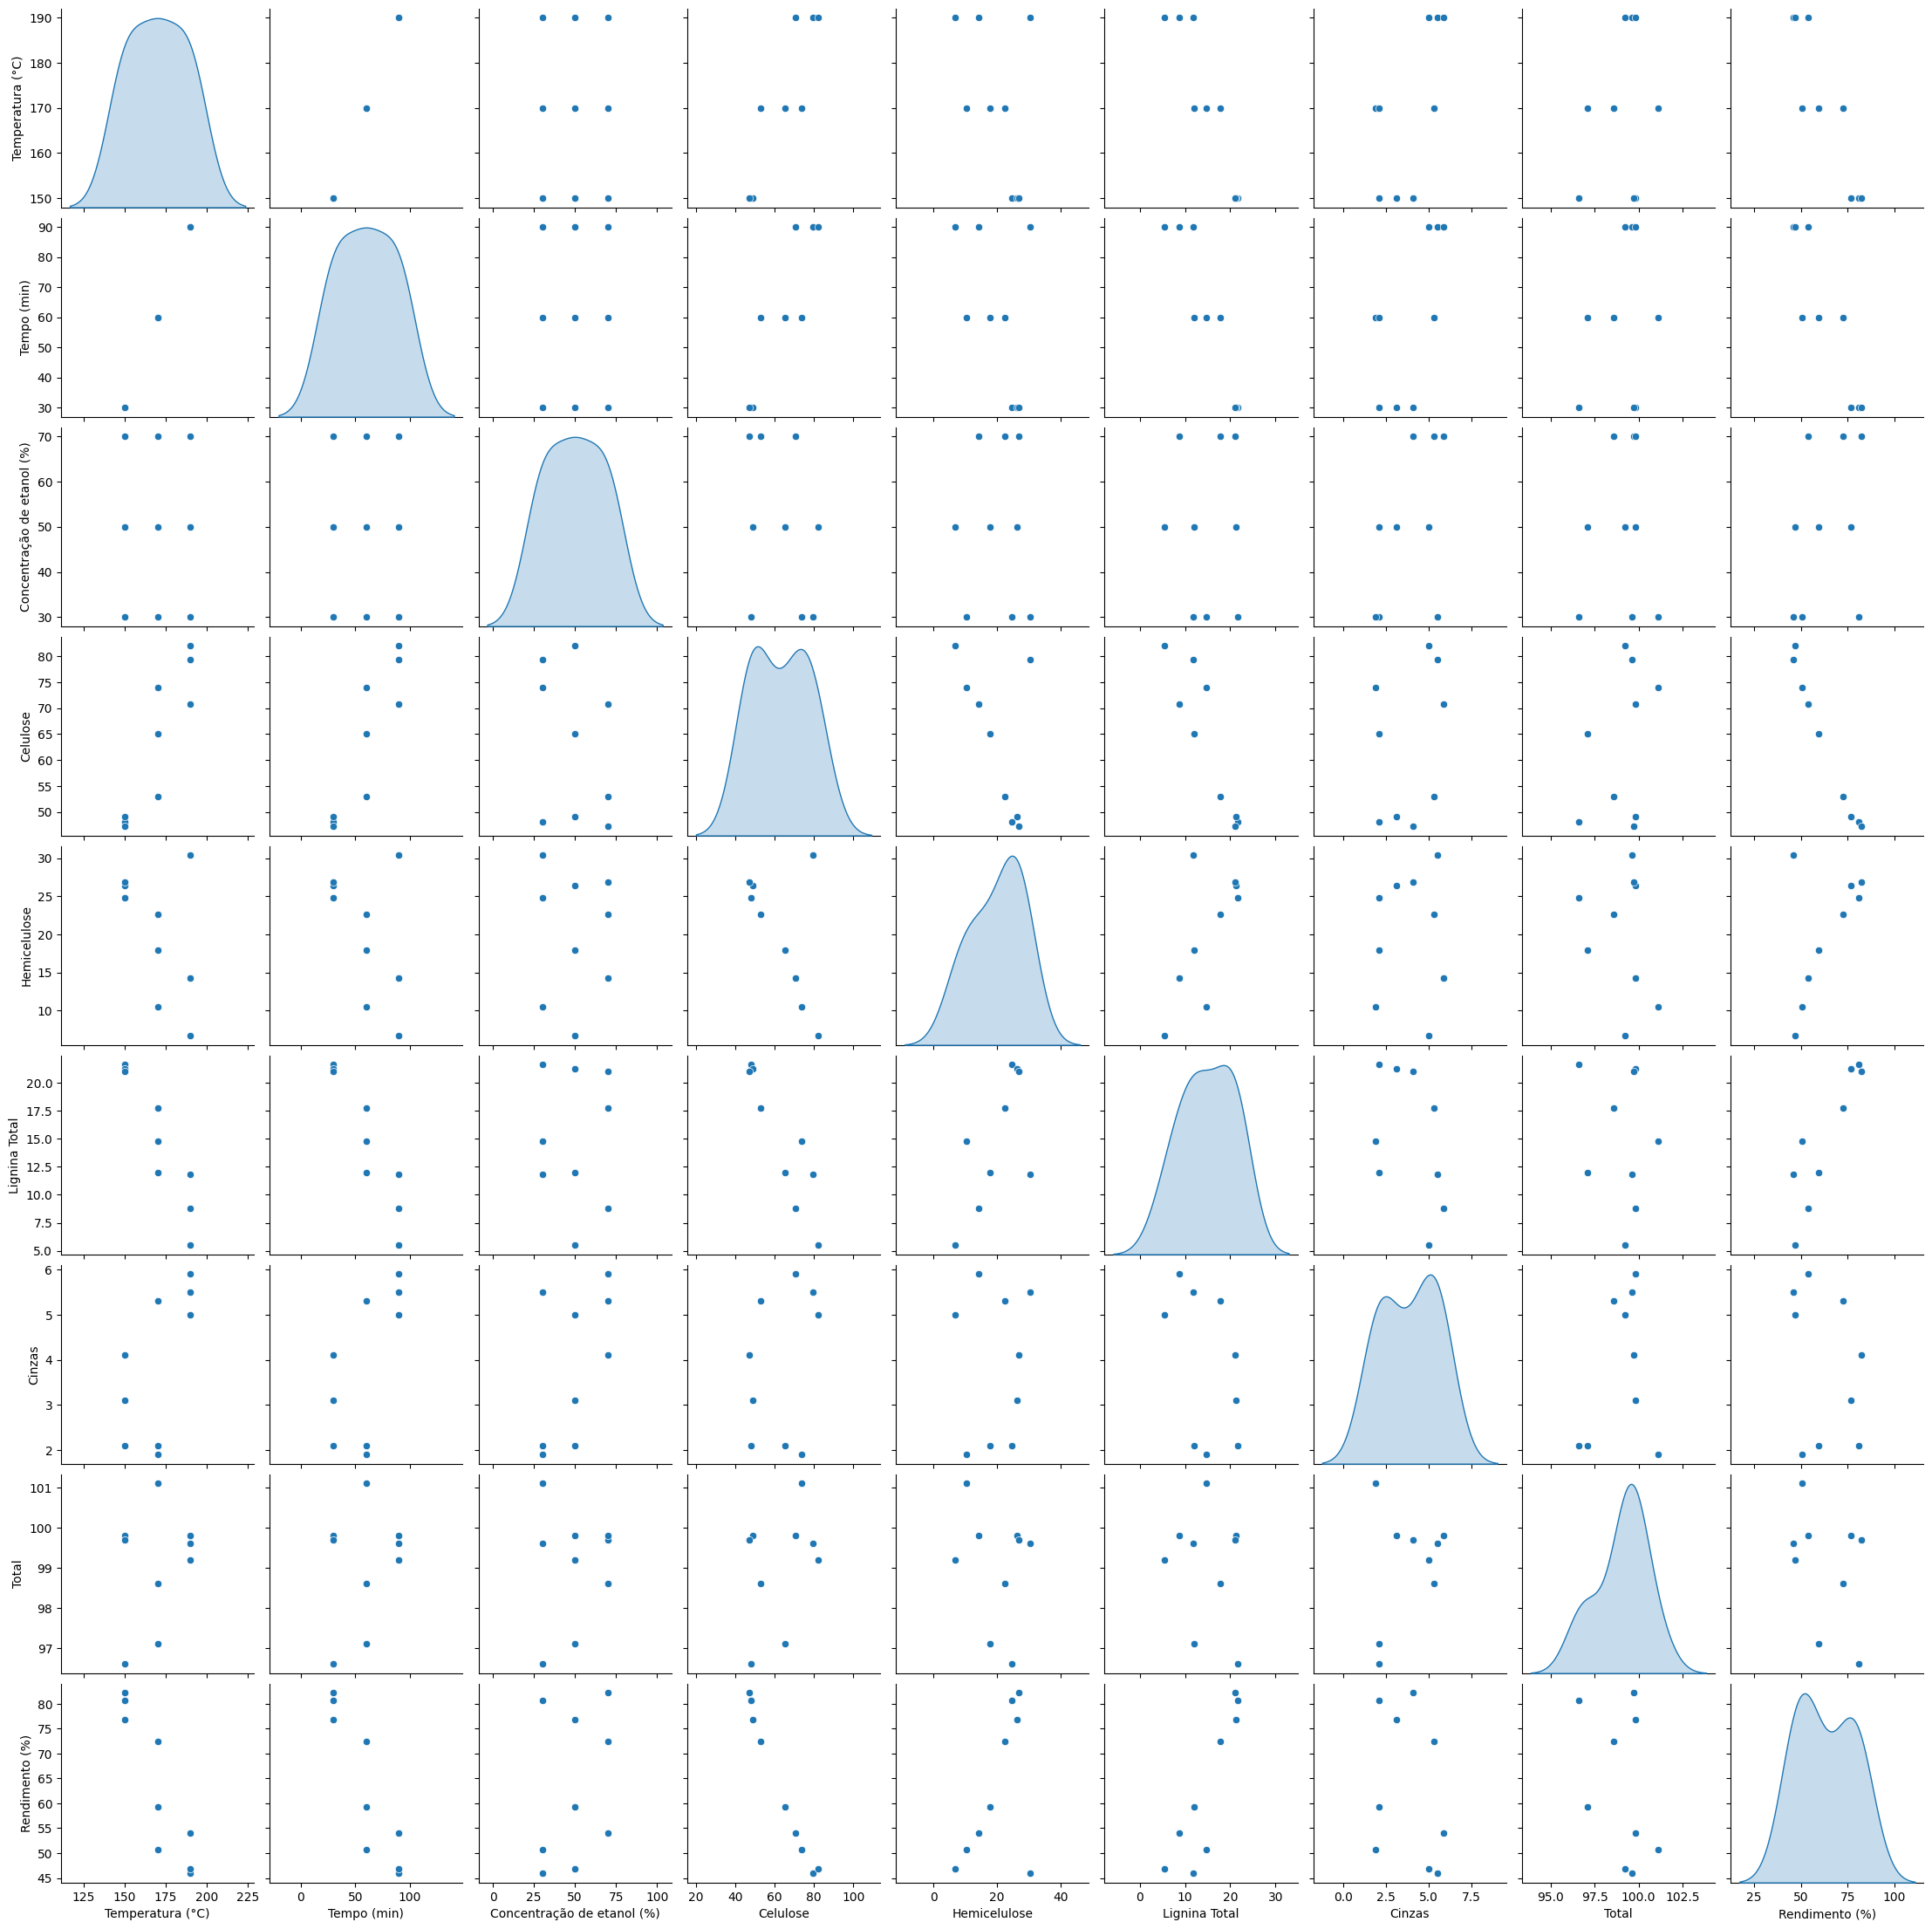

In [4]:
sns.pairplot(Dados, diag_kind='kde')